In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import pandas as pd

2023-11-24 08:56:42.258980: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# load data 
train_csv = pd.read_csv("./train.csv")

In [3]:
train_csv.head(2)

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False


In [4]:
# count files 
import os

count = 0
for _, _, files_list in os.walk('./train_thumbnails/'):
    count += len(files_list)
print('file count:', count)


file count: 513


In [5]:
source = './train_thumbnails/'
files_list = os.listdir(source)
labels = train_csv["label"].unique().tolist()
labels_list = train_csv["label"].tolist()

In [6]:
# split images into subfolders RUN ONCE 
# import shutil
# i=0
# for file in files_list :
#      if (file not in labels ):
#         shutil.move(
#             source + file,
#             f'{source}{labels_list[i]}/'
#             )
#         i += 1

In [7]:
# create data sets
# train_dir = 'drive/MyDrive/DL_Class/DSTI_DL_project/train_thumbnails/'

BATCH_SIZE = 32
# IMG_SIZE = (160, 160)
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                            labels = "inferred",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            subset ="training",
                                                            validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 411 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(source,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 subset = "validation",
                                                                 validation_split = 0.2,
                                                            seed = 123)

Found 513 files belonging to 5 classes.
Using 102 files for validation.


## Data visualization

In [9]:
# import matplotlib.pyplot as plt 
# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(4):
#     # print(class_names[labels[i]])
#     ax = plt.subplot(2, 2, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [10]:
# image batch 
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
# test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 2


In [13]:
# Configure datasets for perf
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [14]:
#  augmentation layers
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip('horizontal'),
tf.keras.layers.RandomFlip('vertical'),
tf.keras.layers.RandomFlip('horizontal_and_vertical'),
tf.keras.layers.RandomRotation(factor=0.2),
#new added layers
tf.keras.layers.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
])

In [15]:
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
# num_classes = len(labels)

# model0 = Sequential([
#   # layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

## Features extraction 

InceptionResnetV2  
MobileNetV3 
MobileNetV3Small  
Xception  49%
ResNet50


In [16]:
# create the base pre-trained model
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    # input_shape=(224, 224, 3),
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

In [17]:
base_model.trainable = False

In [18]:
#
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [19]:
# image_batch,_= next(iter(train_dataset))
# base_model(image_batch).shape

In [20]:
# add a global spatial average pooling layer
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.image.stateless_random_contrast(x, lower=0.1, upper=0.9, seed=123)
x = tf.image.stateless_random_brightness(x, max_delta=0.5, seed=123)
x = tf.image.stateless_random_flip_left_right(x,seed=123)
x = tf.image.stateless_random_flip_up_down(x,seed=123)
x = preprocess_input(x)
x = base_model(x,training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)


In [21]:
# this is the model we will train
model = Model(inputs= inputs, outputs=predictions)

In [22]:
len(model.trainable_variables)

4

In [23]:
# compile model 
base_learning_rate = 1e-6
model.compile(tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
# optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics="accuracy")

# tensorboard 
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [49]:
initial_epochs =20

loss0,accuracy0 = model.evaluate(validation_dataset)

2/2 [==============================] - 10s 643ms/step - loss: 1.4195 - accuracy: 0.5263


In [50]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False


In [51]:
# train the model on the new data for a few epochs
history = model.fit(train_dataset,
          epochs=initial_epochs,
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)


Epoch 1/20
13/13 [==============================] - 76s 5s/step - loss: 1.5853 - accuracy: 0.2993 - val_loss: 1.4538 - val_accuracy: 0.4737
Epoch 2/20
13/13 [==============================] - 83s 5s/step - loss: 1.5542 - accuracy: 0.3577 - val_loss: 1.5406 - val_accuracy: 0.3947
Epoch 3/20
13/13 [==============================] - 81s 5s/step - loss: 1.5676 - accuracy: 0.2968 - val_loss: 1.4194 - val_accuracy: 0.5263
Epoch 4/20
13/13 [==============================] - 81s 5s/step - loss: 1.5639 - accuracy: 0.2920 - val_loss: 1.4177 - val_accuracy: 0.4474
Epoch 5/20
13/13 [==============================] - 73s 4s/step - loss: 1.5614 - accuracy: 0.2871 - val_loss: 1.4899 - val_accuracy: 0.4474
Epoch 6/20
13/13 [==============================] - 73s 5s/step - loss: 1.5632 - accuracy: 0.3236 - val_loss: 1.4310 - val_accuracy: 0.5000
Epoch 7/20
13/13 [==============================] - 90s 6s/step - loss: 1.5721 - accuracy: 0.2822 - val_loss: 1.4335 - val_accuracy: 0.5000
Epoch 8/20
13/13 [==

## learning curve 

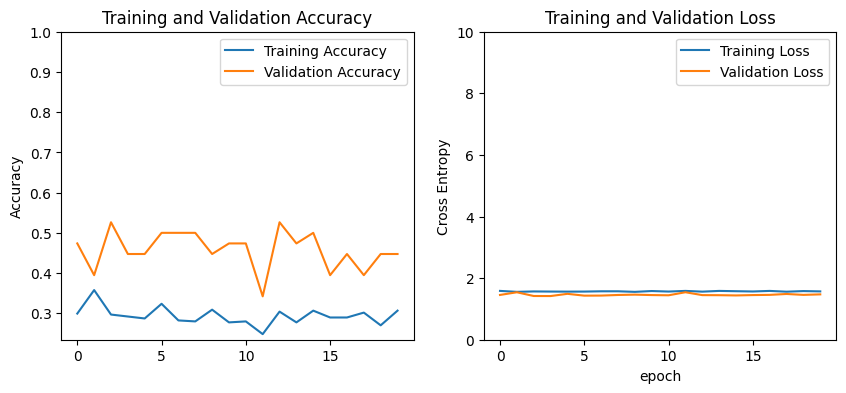

In [52]:
# plot training and validation metrics
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [53]:

os.system('say "end features extraction" ')

0

## Fine-tuning 

In [54]:
# un-freeze model weights
base_model.trainable = True

In [55]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
n_layers = len(base_model.layers)
print(n_layers)
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

427


In [56]:
n_layers*3//4

320

In [57]:

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
n_trainable_layers = n_layers*3//4
for layer in model.layers[:n_trainable_layers]:
   layer.trainable = False
for layer in model.layers[n_trainable_layers:]:
   layer.trainable = True


In [58]:
# from tensorflow.keras.optimizers import SGD
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = "accuracy")

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,
          epochs=total_epochs,
          initial_epoch = history.epoch[-1],
          validation_data = validation_dataset,
          callbacks=tensorboard_callback,
          use_multiprocessing=True)

Epoch 20/30
13/13 [==============================] - 95s 5s/step - loss: 1.5768 - accuracy: 0.2920 - val_loss: 1.5261 - val_accuracy: 0.3947
Epoch 21/30
13/13 [==============================] - 79s 5s/step - loss: 1.5661 - accuracy: 0.2920 - val_loss: 1.4618 - val_accuracy: 0.4474
Epoch 22/30
13/13 [==============================] - 97s 6s/step - loss: 1.5904 - accuracy: 0.2822 - val_loss: 1.4614 - val_accuracy: 0.4474
Epoch 23/30
13/13 [==============================] - 80s 5s/step - loss: 1.5820 - accuracy: 0.3017 - val_loss: 1.4319 - val_accuracy: 0.4737
Epoch 24/30
13/13 [==============================] - 83s 5s/step - loss: 1.5719 - accuracy: 0.2798 - val_loss: 1.4798 - val_accuracy: 0.4211
Epoch 25/30
13/13 [==============================] - 80s 5s/step - loss: 1.5696 - accuracy: 0.3114 - val_loss: 1.4334 - val_accuracy: 0.5000
Epoch 26/30
13/13 [==============================] - 79s 5s/step - loss: 1.5789 - accuracy: 0.2895 - val_loss: 1.4400 - val_accuracy: 0.5526
Epoch 27/30
1

In [59]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

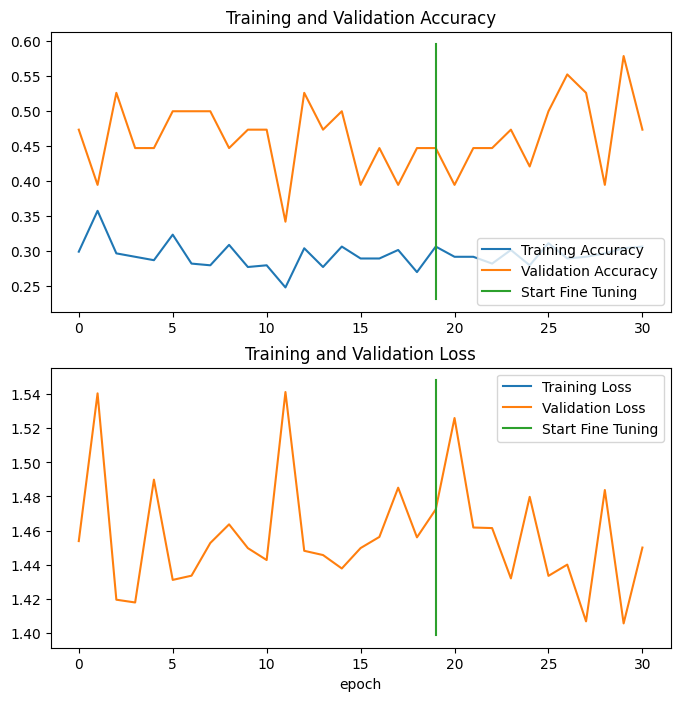

In [66]:
# plot training and validation metrics
import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

2/2 [==============================] - 13s 4s/step - loss: 1.4792 - accuracy: 0.4219


In [62]:
test_image_batch,test_label_batch = next(iter(test_dataset))

In [63]:
predicted_batch = model.predict(test_image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1,)
test_labels = [labels[id] for id in test_label_batch]
predicted_labels = [labels[id] for id in predicted_id]
print("test labels:",test_labels)
print("pred labels:",predicted_labels)

2023-11-24 10:55:52.797387: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model/sequential/random_crop/cond/branch_executed/_10


1/1 [==============================] - 6s 6s/step
test labels: ['HGSC', 'EC', 'HGSC', 'EC', 'CC', 'EC', 'EC', 'MC', 'EC', 'LGSC', 'HGSC', 'LGSC', 'HGSC', 'LGSC', 'EC', 'LGSC', 'MC', 'EC', 'LGSC', 'EC', 'EC', 'HGSC', 'EC', 'EC', 'HGSC', 'EC', 'EC', 'EC', 'MC', 'HGSC', 'MC', 'EC']
pred labels: ['EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC', 'EC']



Not quite quite good !!!

In [64]:
os.system('say "End of file"')

0